# **Libraries**   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

import re
import os

# import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from torchmetrics.functional import accuracy

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from tqdm import tqdm

# **Pre-processing - Training Dataset**   

In [2]:
train_data = pd.read_csv('mbti_1.csv')
train_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
train_data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [4]:
stop_words = stopwords.words('english')

In [5]:
# function to clean the word of any punctuation or special characters
def cleanSentence(sentence):
    # sentence lower
    sentence = sentence.lower()
    # remove url
    cleaned = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',' ',sentence)
    # remove other symbols
    cleaned = re.sub('[^0-9a-z]',' ',cleaned)
    # remove spaces > 1
    cleaned = re.sub(" +", " ", cleaned)
    # remove blank at the begining and end
    cleaned = cleaned.strip()
    # remove stopwords
    cleaned = " ".join([w for w in cleaned.split(' ') if w not in stop_words])
    return cleaned

In [6]:
cleanSentence(train_data.posts[0])

'enfp intj moments sportscenter top ten plays pranks life changing experience life repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace hello enfj7 sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth 84389 84390 welcome stuff game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video games growing current favorite video games cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always a

In [7]:
train_data['posts'] = train_data['posts'].apply(cleanSentence)
train_data.head()

,type,posts
0,INFJ,enfp intj moments sportscenter top ten plays p...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired another silly misconception approaching ...


In [8]:
def length_sentence(sentence):
    
    length = len(sentence.split(" "))
    
    return length

In [9]:
train_data['length'] = train_data['posts'].apply(length_sentence)

In [10]:
lb = preprocessing.LabelBinarizer()
lb_result = lb.fit_transform([str(train_data.loc[i,'type']) for i in range(len(train_data))])
columns=list(lb.classes_)
train_data = pd.concat([train_data['type'], train_data['posts'], train_data['length'], pd.DataFrame(lb_result, columns=list(lb.classes_))],axis=1)

In [11]:
train_data.head()

,type,posts,length,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,INFJ,enfp intj moments sportscenter top ten plays p...,317,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,ENTP,finding lack posts alarming sex boring positio...,572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,INTP,good one course say know blessing curse absolu...,445,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,INTJ,dear intp enjoyed conversation day esoteric ga...,541,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,ENTJ,fired another silly misconception approaching ...,485,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# **Pre-processing - Testing Dataset**   

In [12]:
# INTJ
Divy_Bramhecha = open("Test_file/Divy_Bramhecha.txt")
Divy_Bramhecha = Divy_Bramhecha.readline()
Divy_Bramhecha

'I dont think anyone would be able to live 300 years i am not talking about the physical ability to do so but the mental fortitude unless you decide to live away from civilization it simply is not possible.|||Believe me you would not want to live for that long alone , unless there are others who can live for 300 years as well.|||You cannot enjoy something if you say something to yourself like ëI wanna enjoy this , i think this thing is gonna be funí believe me it doesnít work.|||I think this problem might be face by a lot of people.|||Firstly you should only study stuff that interests you . (obvious)|||Now there are subjects that you school forces you to take and you have no option but to some how score in those subjects. (What i used to think is subjects like history , geography and most of all Hindi are utterly useless , i wanna be a programmer why do i study these)|||But because i had no choice i thought lets give these a try. I started questioning things and when i dug deep into th

In [13]:
cleanSentence(Divy_Bramhecha)

'dont think anyone would able live 300 years talking physical ability mental fortitude unless decide live away civilization simply possible believe would want live long alone unless others live 300 years well cannot enjoy something say something like wanna enjoy think thing gonna fun believe work think problem might face lot people firstly study stuff interests obvious subjects school forces take option score subjects used think subjects like history geography hindi utterly useless wanna programmer study choice thought lets give try started questioning things dug deep events history event took place benefit benefactor questioning finding reasons made like history point unless ya start questioning researching whats necessary exams wont like subject subjects beautiful choose see basically give everything real shot life everything works advice seems ironical dont like subject telling research try also never study exam assignment someone told please study feel like want develop sense want 

In [14]:
# INTP
Valentin_Pyatev = open("Test_file/Valentin_Pyatev.txt")
Valentin_Pyatev = Valentin_Pyatev.readline()
Valentin_Pyatev

'These are words Britons should heed immediately.  Despite state surveillance now being more overbearing than ever, the general public remains blissfully ignorant of its presence.  Our denial daydreams consist of the unintelligible adage ìif you have nothing to hide, then you have nothing to fear.îlet this pitiful defence should have been forcibly denounced in the wake of the unsettling Snowden revelations almost five years ago. We are all too willing to allow the government to further legislate against privacy, and to simply let fringe human rights groups take on the brunt of a battle for it that should be fought on the national scale. Our vote to leave the EU was supposedly to reclaim \'sovereignty\' ñ but weíve handed it back to a technophobic, anti-privacy government soon to be unshackled by protective EU rights and data privacy law. In taking aim at the terrorist threat we have instead shot ourselves in the foot.  Liberty has been caught in the crossfire.  Our attitude must change

In [15]:
cleanSentence(Valentin_Pyatev)

'words britons heed immediately despite state surveillance overbearing ever general public remains blissfully ignorant presence denial daydreams consist unintelligible adage nothing hide nothing fear let pitiful defence forcibly denounced wake unsettling snowden revelations almost five years ago willing allow government legislate privacy simply let fringe human rights groups take brunt battle fought national scale vote leave eu supposedly reclaim sovereignty handed back technophobic anti privacy government soon unshackled protective eu rights data privacy law taking aim terrorist threat instead shot foot liberty caught crossfire attitude must change finally one striking changes made redrafting addition fire smoke based imagery wanted convey employing techniques oppressiveness widespread nature prejudice southern society initially used metaphor smokescreen obscuring truth show henry enlightenment starting help rethink firm beliefs father imprinted smoke concealing truth really muddle ma

In [16]:
# INTP
Sanayapoem = open("Test_file/Sanayapoem.txt")
Sanayapoem = Sanayapoem.readline()
Sanayapoem

'They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm Iím not asking for attention Thereís a reason I have apprehensions I just need you to see What has become of me||| I know Iím going crazy But they think my thoughts are just hazy When in that chaos, in that confusion Iím crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that weíre all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake weíre not guarded||| Donít you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental

In [17]:
cleanSentence(Sanayapoem)

'act like care tell share carve stories arm doctor calls self harm asking attention reason apprehensions need see become know going crazy think thoughts hazy chaos confusion crying help escape delusions mental health state mind one keep assistance denied failed attempts fight blaze treat like passing phase well stop mental illness real understand made steel brush issues carpet make seem like mistake guarded realise problem needs addressed starting home nest keep mouths shut things instead caring broken wings use social stigma mental illness even enigma look around see numbers affected hiding covers issue needs discussed looked upon disgust mental illness needs accepted people protected let give direction people need affection darkness must escaped lost saved bring change something strange new year time eradicate fear recognise wrists knives stop mental illness taking lives let break convention start suicide prevention hoping festival lights drives darkness mental illness away'

In [18]:
all_posts = open("Test_file/All_text.txt")
all_posts = all_posts.readlines()
a =['']
for i in all_posts:
    a[0]=a[0]+i

In [19]:
all_posts = a[0].split('&&&')
all_posts

['"Hope Y\'all enjoy Mila Kunis\' birthday tommorow"|||"We had decided to enact the hardships faced by a person living in poverty. When we started jotting down words we ran into severe communication problems as we wanted to enable a flexible exchange of ideas to make the most out of this opportunity.||| There were many conflicts of personal interest in deciding the style of performance. We eventually decided to vote on the several different ideas and start working on the best one. But, I would prefer to cut down the time of the skit, if I were given a chance to present it again.||| This would ensure that our message won’t get lost in complexity. I had also learnt about the various personalities of people and how to manage and even befriend them."|||"World Dyslexia Awareness week runs from 2nd October to 8th October in the year of 2017. So, in order to gain insight into the minds of the dyslexic, and to highlight the problems that the dyslexic are facing to our school, we decided to cre

In [20]:
all_posts = all_posts[:13]
all_posts

['"Hope Y\'all enjoy Mila Kunis\' birthday tommorow"|||"We had decided to enact the hardships faced by a person living in poverty. When we started jotting down words we ran into severe communication problems as we wanted to enable a flexible exchange of ideas to make the most out of this opportunity.||| There were many conflicts of personal interest in deciding the style of performance. We eventually decided to vote on the several different ideas and start working on the best one. But, I would prefer to cut down the time of the skit, if I were given a chance to present it again.||| This would ensure that our message won’t get lost in complexity. I had also learnt about the various personalities of people and how to manage and even befriend them."|||"World Dyslexia Awareness week runs from 2nd October to 8th October in the year of 2017. So, in order to gain insight into the minds of the dyslexic, and to highlight the problems that the dyslexic are facing to our school, we decided to cre

In [21]:
all_posts[0]

'"Hope Y\'all enjoy Mila Kunis\' birthday tommorow"|||"We had decided to enact the hardships faced by a person living in poverty. When we started jotting down words we ran into severe communication problems as we wanted to enable a flexible exchange of ideas to make the most out of this opportunity.||| There were many conflicts of personal interest in deciding the style of performance. We eventually decided to vote on the several different ideas and start working on the best one. But, I would prefer to cut down the time of the skit, if I were given a chance to present it again.||| This would ensure that our message won’t get lost in complexity. I had also learnt about the various personalities of people and how to manage and even befriend them."|||"World Dyslexia Awareness week runs from 2nd October to 8th October in the year of 2017. So, in order to gain insight into the minds of the dyslexic, and to highlight the problems that the dyslexic are facing to our school, we decided to crea

In [22]:
all_posts.append(cleanSentence(Divy_Bramhecha))
all_posts.append(cleanSentence(Valentin_Pyatev))
all_posts.append(cleanSentence(Sanayapoem))

In [23]:
test_data = pd.DataFrame(all_posts, columns = ['posts'])
test_data['posts'] = test_data['posts'].apply(cleanSentence)
test_data

,posts
0,hope enjoy mila kunis birthday tommorow decide...
1,walking among sharks big family even count cra...
2,diya making hand painted diya indian festival ...
3,graffiti cas one best experience till date ib ...
4,maybe somethings meant maybe people worth tee ...
5,photograph river 1038 miles north western us r...
6,aim particular experience basically spread awa...
7,cas reflection thailand trip went thailand 28 ...
8,february 8 2018 cas period house making compet...
9,idea learn new things receive new experience m...


In [24]:
test_data = pd.concat([test_data, pd.DataFrame(columns=columns)], sort=False)
test_data.loc[:, columns] = 0
test_data

,posts,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,hope enjoy mila kunis birthday tommorow decide...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,walking among sharks big family even count cra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,diya making hand painted diya indian festival ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,graffiti cas one best experience till date ib ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,maybe somethings meant maybe people worth tee ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,photograph river 1038 miles north western us r...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,aim particular experience basically spread awa...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,cas reflection thailand trip went thailand 28 ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,february 8 2018 cas period house making compet...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,idea learn new things receive new experience m...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
test_labels = open("Test_file/MBTI.txt")
test_labels = test_labels.read().splitlines()
test_labels

['ENFP',
 'ENFP',
 'ENFP',
 'ESFP',
 'ENFP',
 'ENTP',
 'ESFJ',
 'INFP',
 'ESFP',
 'ISFJ',
 'ESFP',
 'ENFP',
 'ISTJ']

# **EDA - Training Dataset**   

## **Distribution of Personabilities**

In [26]:
cnt_type = train_data['type'].value_counts()
cnt_type

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

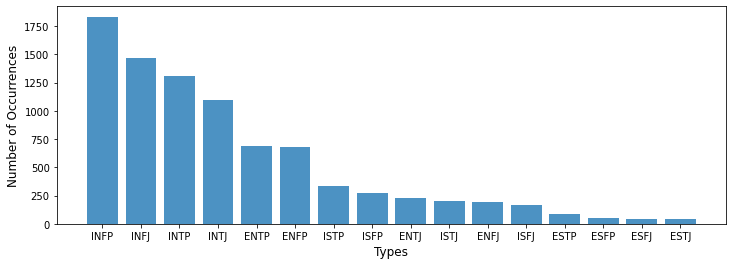

In [27]:
plt.figure(figsize=(12,4))
plt.bar(cnt_type.index, cnt_type.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.savefig('DistributionofPersonabilities.png')
plt.show()

## **Distribution of Words Number**

In [28]:
CountL = train_data['posts'].apply(lambda x: len(x.split()))

In [29]:
min(CountL),max(CountL)

(3, 927)

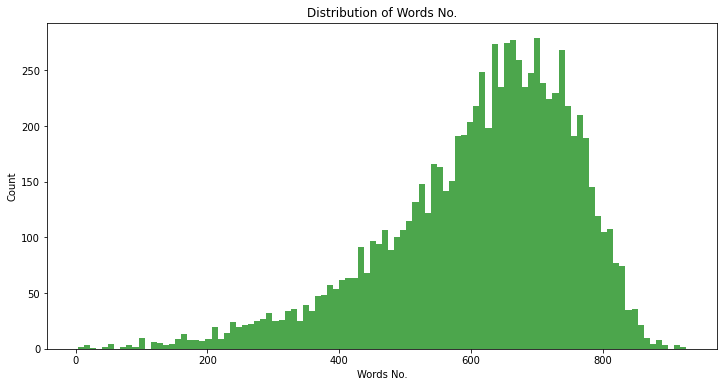

In [30]:
plt.figure(figsize=(12, 6))
plt.hist(CountL,100,color = 'green',alpha = 0.7)
plt.xlabel('Words No.')
plt.ylabel('Count')
plt.title('Distribution of Words No.')
plt.savefig('DistWordsNo.png')

### **BertTokenizer**

We need to convert the raw text into a list of tokens.

In [31]:
from transformers import BertTokenizerFast as BertTokenizer, BertModel,AdamW, get_linear_schedule_with_warmup,logging

2022-11-13 19:20:53.860011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 19:20:56.909344: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 19:20:57.422378: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 19:21:15.227362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [32]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [33]:
train_data = train_data.drop(['type', 'length'], axis=1)

In [34]:
train_df, val_df = train_test_split(train_data, test_size=0.2)
test_df = test_data

In [35]:
train_df.shape, val_df.shape, test_df.shape

((6940, 17), (1735, 17), (16, 17))

In [36]:
MAX_TOKEN_COUNT = 512

In [37]:
logging.set_verbosity_error()
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [38]:
class PersonabilityDataset(Dataset):
    
    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: BertTokenizer, 
        max_token_len: int = 512
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        
        posts = data_row.posts
        labels = data_row[columns]
        
        encoding = self.tokenizer.encode_plus(
            posts,
            # add_special_tokens： Whether or not to encode the sequences with the special tokens relative to their model
            add_special_tokens=True,
            # max_length： Controls the maximum length to use by one of the truncation/padding parameters
            max_length=self.max_token_len,
            # Whether to return token type IDs
            return_token_type_ids=False, 
            # Activates and controls padding
            padding="max_length", 
            # Activates and controls truncation
            truncation=True, 
            # Whether to return the attention mask.
            return_attention_mask=True, 
            # Return PyTorch torch.Tensor objects.
            return_tensors='pt', 
        )
        
        return dict(
            posts=posts,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [39]:
class PersonabilityDataModule(pl.LightningDataModule):
    
    def __init__(self, train_df, val_df, test_df, tokenizer, batch_size, max_token_len):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = PersonabilityDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.val_dataset = PersonabilityDataset(
            self.val_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = PersonabilityDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=10
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=10
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=10
        )

In [40]:
N_EPOCHS = 10
BATCH_SIZE = 16

In [41]:
data_module = PersonabilityDataModule(
    train_df,
    val_df,
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

# **Model**

In [42]:
class PersonabilityDetector(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()  

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)    
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

In [43]:
if os.path.exists('/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/lightning_logs') == True:
    !rm -rf /scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/lightning_logs
if os.path.exists('/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints') == True:
    !rm -rf /scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints

In [44]:
folderPath = os.path.abspath('')
folderPath

'/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project'

In [45]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5

model = PersonabilityDetector(n_classes=len(columns), n_warmup_steps=warmup_steps, n_training_steps=total_training_steps )

#To save the model
checkpoint_callback = ModelCheckpoint(
    dirpath="{}/checkpoints".format(folderPath),
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(folderPath, name="lightning_logs")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger=logger,
    gpus=1,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,   
    enable_progress_bar = False
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
if os.path.exists('{}/lightning_logs'.format(folderPath)) == False:
  os.mkdir('{}/lightning_logs'.format(folderPath))

In [47]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 12.3 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.290   Total estimated model params size (MB)
Epoch 0, global step 434: 'val_loss' reached 0.21307 (best 0.21307), saving model to '/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints/best-checkpoint.ckpt' as top 1
Epoch 1, global step 868: 'val_loss' reached 0.17035 (best 0.17035), saving model to '/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints/best-checkpoint.ckpt' as top 1
Epoch 2, global step 1302: 'val_loss' reached 0.13630 (best 0.13630), saving model to '/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints/best-checkpoint.ckpt' as t

In [48]:
trained_model = PersonabilityDetector.load_from_checkpoint(
  '/scratch/project_2006400/Introduction_to_Data_Science_2022/mini_project/checkpoints/best-checkpoint.ckpt',
  n_classes=len(columns)
)
trained_model.eval()
trained_model.freeze()

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

test_dataset = PersonabilityDataset(
    test_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

predictions = []

for item in tqdm(test_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    predictions.append(prediction.flatten())

predictions = torch.stack(predictions).detach().cpu()

100%|██████████| 16/16 [00:00<00:00, 72.35it/s]


In [75]:
index_pred = []
for i in range(len(predictions)):
    ind = torch.argmax(predictions[i])
    index_pred.append(ind)

In [76]:
index_pred

[tensor(8),
 tensor(8),
 tensor(10),
 tensor(8),
 tensor(9),
 tensor(8),
 tensor(8),
 tensor(8),
 tensor(10),
 tensor(8),
 tensor(8),
 tensor(1),
 tensor(11),
 tensor(11),
 tensor(8),
 tensor(8)]

In [77]:
columns 

['ENFJ',
 'ENFP',
 'ENTJ',
 'ENTP',
 'ESFJ',
 'ESFP',
 'ESTJ',
 'ESTP',
 'INFJ',
 'INFP',
 'INTJ',
 'INTP',
 'ISFJ',
 'ISFP',
 'ISTJ',
 'ISTP']

In [78]:
test_pred = [columns[8], columns[8], columns[10], columns[8], columns[9], columns[8],
             columns[8], columns[8],columns[10],columns[8], columns[8], columns[1],
             columns[11], columns[11], columns[8], columns[8]]
test_pred

['INFJ',
 'INFJ',
 'INTJ',
 'INFJ',
 'INFP',
 'INFJ',
 'INFJ',
 'INFJ',
 'INTJ',
 'INFJ',
 'INFJ',
 'ENFP',
 'INTP',
 'INTP',
 'INFJ',
 'INFJ']

In [88]:
test_labels.append('INTJ')
test_labels.append('INTP')
test_labels.append('INTP')

In [89]:
pred = pd.DataFrame(test_labels, columns = ['test_labels'])

In [90]:
pred['test_pred'] = test_pred

In [91]:
pred

,test_labels,test_pred
0,ENFP,INFJ
1,ENFP,INFJ
2,ENFP,INTJ
3,ESFP,INFJ
4,ENFP,INFP
5,ENTP,INFJ
6,ESFJ,INFJ
7,INFP,INFJ
8,ESFP,INTJ
9,ISFJ,INFJ
